## This notebook contains my approach to create a CNN model for recognizing and calculate handwritten mathematic equations. This research is based on a dataset of handwritten digits and mathematic symbols from Kaggle (https://www.kaggle.com/datasets/sagyamthapa/handwritten-math-symbols/data) and a Prahav Dhawan's notebook (https://www.kaggle.com/code/pranavdhawan/calculatormodel).

In [ ]:
import cv2
import os
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd
import tensorflow as tf
import imutils
from PIL import Image
from tensorflow import keras
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.layers import Input, Conv2D, Activation, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization
from tensorflow.keras.initializers import glorot_uniform
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam, SGD
from tensorflow.keras.regularizers import l2
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import LearningRateScheduler, ModelCheckpoint
from tensorflow.keras import utils
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from imutils.contours import sort_contours

### Data preprocessing.

Connectiong to Google Disk and an Kaggle API

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

!cp "/content/drive/MyDrive/Kaggle/kaggle.json" kaggle.json

!mkdir ~/.kaggle

!mv kaggle.json ~/.kaggle

!chmod 600 /root/.kaggle/kaggle.json

Mounted at /content/drive


Downloading dataset

In [ ]:
!kaggle datasets download -d sagyamthapa/handwritten-math-symbols

 84% 33.0M/39.4M [00:00<00:00, 80.3MB/s]
100% 39.4M/39.4M [00:00<00:00, 80.6MB/s]


In [ ]:
!unzip /content/handwritten-math-symbols.zip

Выходные данные были обрезаны до нескольких последних строк (5000).
  inflating: dataset/9/77355.jpg     
  inflating: dataset/9/77476.jpg     
  inflating: dataset/9/77630.jpg     
  inflating: dataset/9/78431.jpg     
  inflating: dataset/9/78565.jpg     
  inflating: dataset/9/78681.jpg     
  inflating: dataset/9/78787.jpg     
  inflating: dataset/9/78790.jpg     
  inflating: dataset/9/79205.jpg     
  inflating: dataset/9/79548.jpg     
  inflating: dataset/9/79700.jpg     
  inflating: dataset/9/79719.jpg     
  inflating: dataset/9/79827.jpg     
  inflating: dataset/9/79838.jpg     
  inflating: dataset/9/7EsEQbyw.png  
  inflating: dataset/9/7Twsh8gG.png  
  inflating: dataset/9/7lr2Xc7w.png  
  inflating: dataset/9/7xp1s3sL.png  
  inflating: dataset/9/7zxVuQiG.png  
  inflating: dataset/9/80088.jpg     
  inflating: dataset/9/81331.jpg     
  inflating: dataset/9/81343.jpg     
  inflating: dataset/9/81992.jpg     
  inflating: dataset/9/82424.jpg     
  inflating: dataset

Let's look at dataset folder

In [ ]:
!ls /content/dataset

0  1  2  3  4  5  6  7	8  9  add  dec	div  eq  mul  sub  x  y  z


That's all of the symbols classes. For now we need only digits, arithmetic operations and dots. So let's delete all other classes.

In [ ]:
import shutil
shutil.rmtree('/content/dataset/x')
shutil.rmtree('/content/dataset/y')
shutil.rmtree('/content/dataset/z')
shutil.rmtree('/content/dataset/eq')

Let's look at amount of data and our final list of classes.

In [ ]:
# creating a x and an y for train/test splitting
x = []
y = []

datadir = '/content/dataset'
folders = os.listdir(datadir)
# removing this directory because it's not one of the class folders
folders.remove('.directory')

for folder in folders:
  path = os.path.join(datadir, folder)
  for images in os.listdir(path):
    img = cv2.imread(os.path.join(path, images))
    x.append(img)
    y.append(folder)

print(len(x))
print(len(y))
print(f'labels : {list(set(y))}')

8375
8375
labels : ['9', '7', '5', '0', 'add', 'dec', 'mul', '3', 'sub', '4', '2', '1', 'div', '6', '8']


There's one NoneType, so we'll delete it.

In [ ]:
x_clear = []
y_clear = []

for i in range(len(x)):
  try:
    if x[i].any():
      x_clear.append(x[i])
      y_clear.append(y[i])
  except AttributeError:
    print(x[i])
    print(y[i])
    continue

del x[:]
del x
del y[:]
del y

print(len(x_clear))
print(len(y_clear))

None
9
8374
8374


That's better. So now let's examine our classes for better understanding.

Firstly, we'll look at images we have.

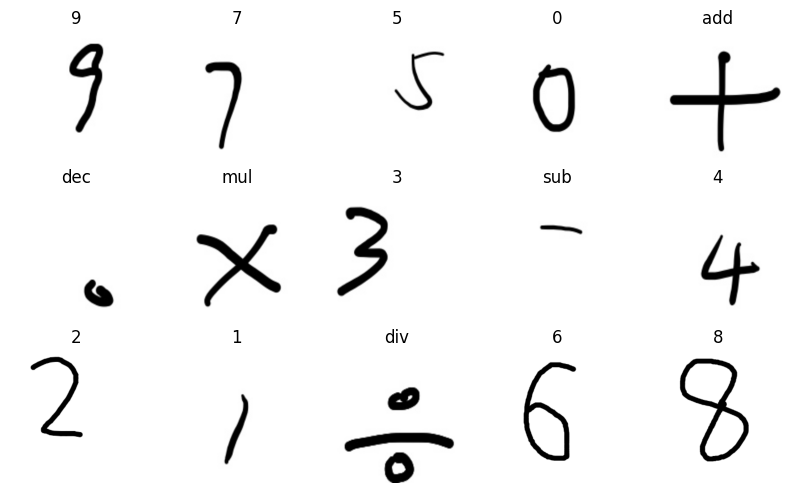

In [ ]:
figure = plt.figure(figsize=(10, 10))

j = 0
for i in list(set(y_clear)):
    idx = y_clear.index(i)
    img = x_clear[idx]
    img = cv2.resize(img, (256, 256))
    figure.add_subplot(5, 5, j+1)
    plt.imshow(img)
    plt.axis('off')
    plt.title(i)
    j += 1

Plotting a class distribution.

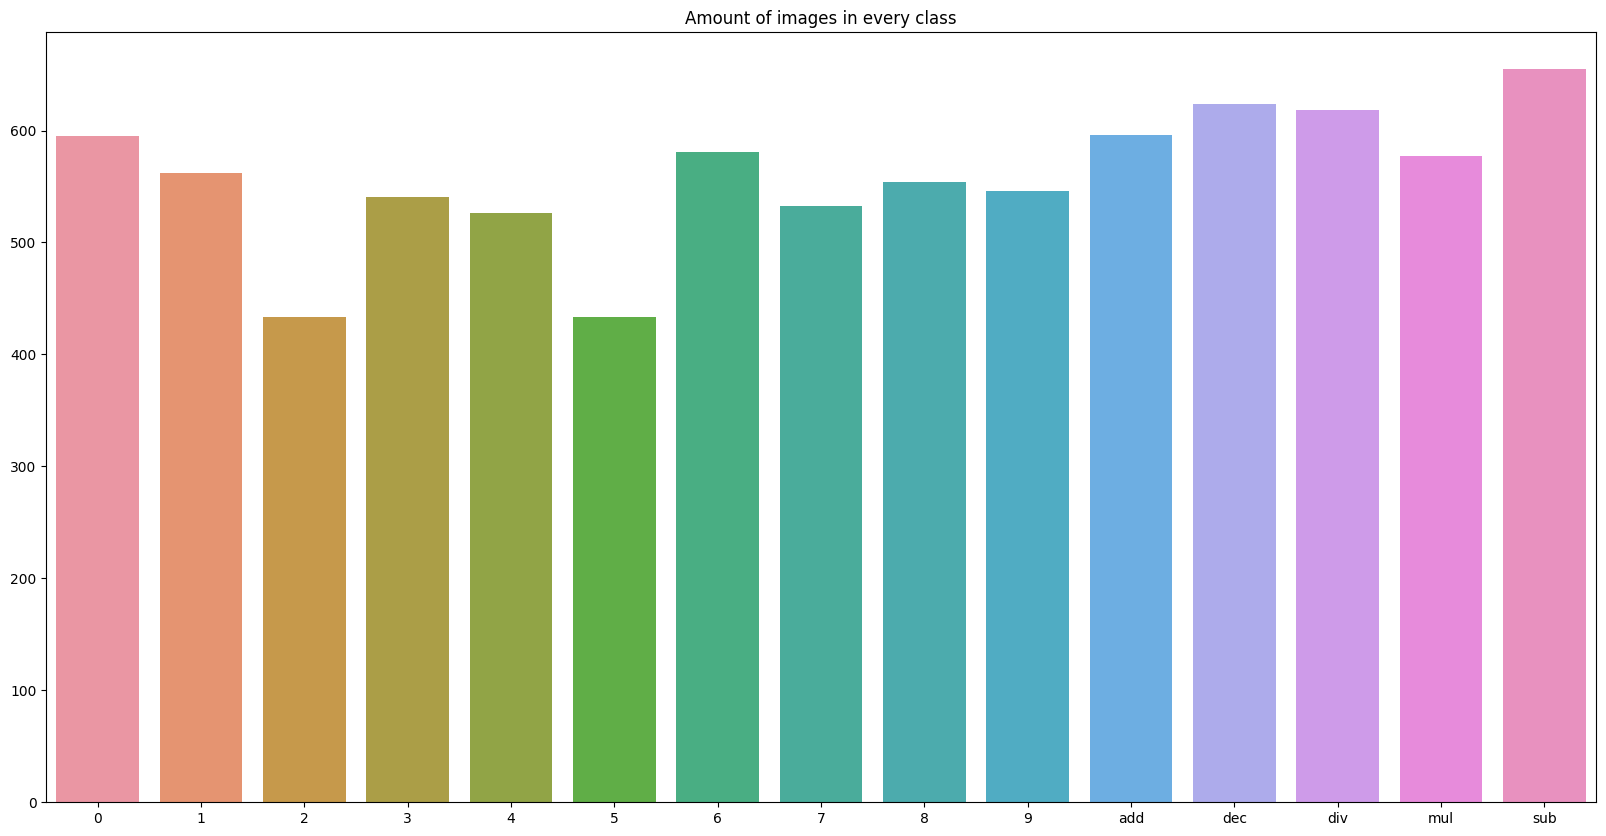

In [ ]:
figure = plt.figure(figsize=(20, 10))

unique, count = np.unique(y_clear, return_counts=True)
sns.barplot(x=unique, y=count).set_title("Amount of images in every class")

plt.show()

As we can see, there's some differences in distribution, but nothing extraordinary.

Now we'll change images a little bit - we'll make images black and white to unify train images and images (which we'll also make b&w) we'll be predicting in the future.

In [ ]:
X = []

for i in range(len(x_clear)):
  img = x_clear[i]
  # turn image to grayscale
  img_gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
  # make it b&w
  threshold_image = cv2.threshold(img_gray, 0, 255, cv2.THRESH_BINARY_INV|cv2.THRESH_OTSU)[1]
  threshold_image = cv2.resize(threshold_image, (32, 32))
  X.append(threshold_image)

print(len(X))

8374


In [ ]:
# renaming our string classes with numbers
label_encoder = LabelEncoder()
y_clear = label_encoder.fit_transform(y_clear)
print(len(y_clear))

8374


Splitting data into train and test.

In [ ]:
X_train, X_test, Y_train, Y_test = train_test_split(X, y_clear, test_size=0.2)

Check the train/test data distribution.

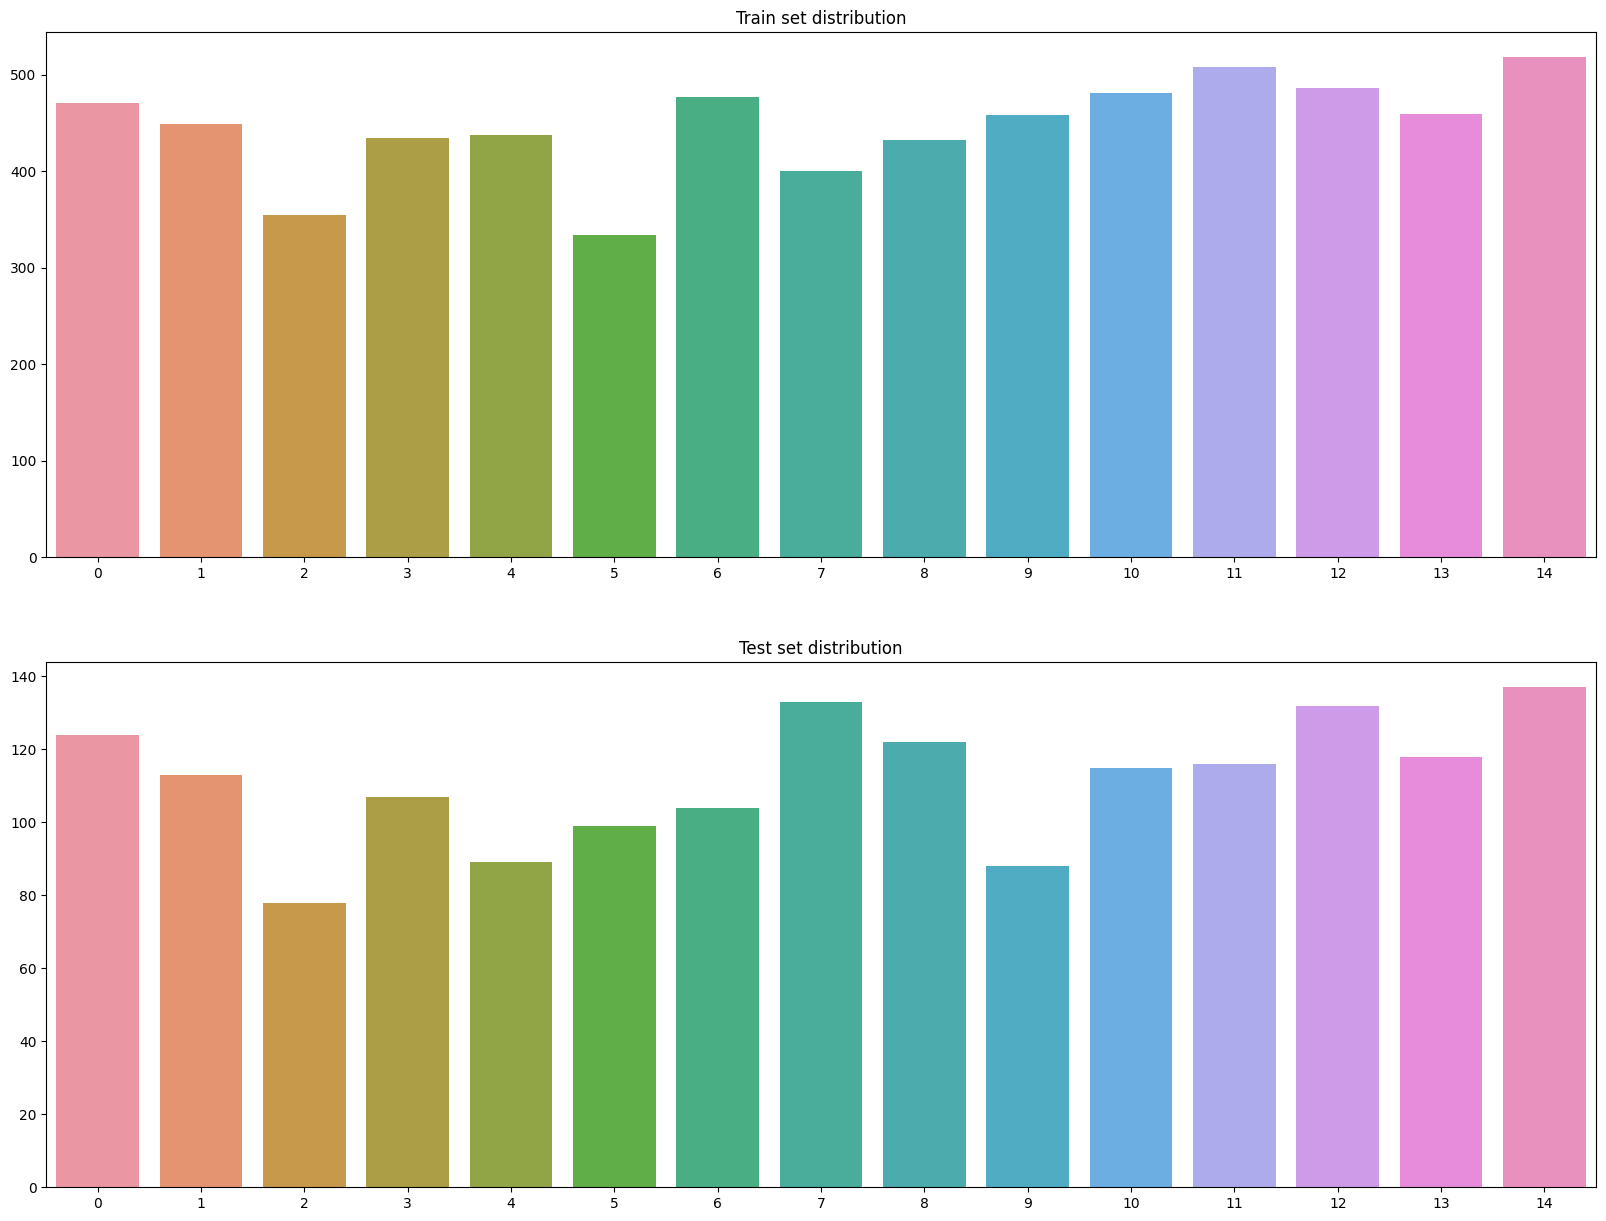

In [ ]:
figure = plt.figure(figsize=(20, 15))

figure.add_subplot(2, 1, 1)
unique_train, count_train = np.unique(Y_train, return_counts=True)
sns.barplot(x=unique_train, y=count_train).set_title("Train set distribution")

figure.add_subplot(2, 1, 2)
unique_test, count_test = np.unique(Y_test, return_counts=True)
sns.barplot(x=unique_test, y=count_test).set_title("Test set distribution")

plt.show()

Distributions are almost the same.

Few last steps before constructing and fitting model.

In [ ]:
# converting sets to np.arrays
X_train = np.array(X_train)
X_test = np.array(X_test)
Y_train = np.array(Y_train)
Y_test = np.array(Y_test)

# converting the target variables
# Y_train and Y_test to categorical format
Y_train = to_categorical(Y_train)
Y_test = to_categorical(Y_test)

# expanding arrays' dimensions
# to fit the deep learning framework
X_train = np.expand_dims(X_train, axis=-1)
X_test = np.expand_dims(X_test, axis=-1)

# normalizing the pixel values to
# scale it between 0 and 1
X_train = X_train/255.
X_test = X_test/255.

print(X_train.shape)
print(X_test.shape)
print(Y_train.shape)
print(Y_test.shape)

(6699, 32, 32, 1)
(1675, 32, 32, 1)
(6699, 15)
(1675, 15)


### Constructing model architecture

In [ ]:
def define_model():
  # adding a regularizer to prevent overfitting
  regularizer = l2(l2=0.01)

  model = Sequential()

  # first convolutional layer 32x32
  model.add(Conv2D(32, (5, 5),
                   padding = 'same',
                   activation='relu',
                   name='conv1',
                   activity_regularizer=regularizer,
                   input_shape=(32, 32, 1)))
  # ...and MaxPooling right after
  model.add(MaxPooling2D(pool_size=(2, 2)))

  # second convolutional layer 64x64
  model.add(Conv2D(64, (5, 5),
                   padding = 'same',
                   activation='relu',
                   name='conv2',
                   activity_regularizer=regularizer))
  # ...and MaxPooling right after
  model.add(MaxPooling2D(pool_size=(2, 2)))

  # third convolutional layer 128x128
  model.add(Conv2D(128, (5, 5),
                   padding = 'same',
                   activation='relu',
                   name='conv3',
                   activity_regularizer=regularizer))
  # ...and MaxPooling right after
  model.add(MaxPooling2D(pool_size=(2, 2)))

  # flatten layer to a vector
  model.add(Flatten())

  # adding fully connected
  model.add(Dense(256, activation='relu', name='fc1'))
  # ...and dropout right after
  model.add(Dropout(0.3))
  # adding fully connected
  model.add(Dense(124, activation='relu', name='fc2'))
  # ...and dropout right after
  model.add(Dropout(0.3))
  # adding fully connected
  model.add(Dense(64, activation='relu', name='fc3'))
  # ...and dropout right after
  model.add(Dropout(0.3))

  # and a final layer
  model.add(Dense(15, activation='sigmoid', name='out'))

  # compile it
  model.compile(loss='categorical_crossentropy',
                optimizer='adam',
                metrics=['accuracy'])

  return model

Model archtecture

In [ ]:
model = define_model()
model.summary()

Model: "sequential_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1 (Conv2D)              (None, 32, 32, 32)        832       
                                                                 
 max_pooling2d_21 (MaxPooli  (None, 16, 16, 32)        0         
 ng2D)                                                           
                                                                 
 conv2 (Conv2D)              (None, 16, 16, 64)        51264     
                                                                 
 max_pooling2d_22 (MaxPooli  (None, 8, 8, 64)          0         
 ng2D)                                                           
                                                                 
 conv3 (Conv2D)              (None, 8, 8, 128)         204928    
                                                                 
 max_pooling2d_23 (MaxPooli  (None, 4, 4, 128)        

Next let's add a scheduler to regulate fitting process and callbacks to save weights of the strongest model.

In [ ]:
def step_decay(epoch):
  initial_learning_rate = 0.001
  dropEvery = 7
  factor = 0.5
  lr = initial_learning_rate*(factor**np.floor((1 + epoch)/dropEvery))
  return float(lr)

checkpoint = ModelCheckpoint('best.h5',
                             monitor='val_loss',
                             save_best_only=True,
                             verbose=1,
                             mode='min')

callbacks = [checkpoint, LearningRateScheduler(step_decay)]

And last thing before training our model is augmentations to widen dataset and prevent possible overfitting.

In [ ]:
# i've chosen the most suitable augmentations for the task
augmentations = ImageDataGenerator(zoom_range=0.2,
                                   rotation_range=10,
                                   shear_range=0.2,
                                   width_shift_range=0.1,
                                   height_shift_range=0.1)

### And, finally, fitting it

In [ ]:
history = model.fit(
    augmentations.flow(X_train, Y_train, batch_size=64),
    batch_size=128,
    epochs=15,
    validation_data=(X_test, Y_test)
    )

Epoch 1/25
105/105 [==============================] - 25s 217ms/step - loss: 2.7562 - accuracy: 0.0748 - val_loss: 2.7113 - val_accuracy: 0.0740
Epoch 2/25
105/105 [==============================] - 23s 223ms/step - loss: 2.5760 - accuracy: 0.1237 - val_loss: 2.1335 - val_accuracy: 0.1910
Epoch 3/25
105/105 [==============================] - 24s 224ms/step - loss: 1.8651 - accuracy: 0.3114 - val_loss: 0.9828 - val_accuracy: 0.7367
Epoch 4/25
105/105 [==============================] - 23s 224ms/step - loss: 1.0308 - accuracy: 0.6611 - val_loss: 0.4566 - val_accuracy: 0.9063
Epoch 5/25
105/105 [==============================] - 24s 224ms/step - loss: 0.6028 - accuracy: 0.8365 - val_loss: 0.2803 - val_accuracy: 0.9552
Epoch 6/25
105/105 [==============================] - 23s 223ms/step - loss: 0.4138 - accuracy: 0.8973 - val_loss: 0.2172 - val_accuracy: 0.9725
Epoch 7/25
105/105 [==============================] - 24s 224ms/step - loss: 0.3106 - accuracy: 0.9280 - val_loss: 0.1752 - val_ac

### Analyzing results

Let's plot the accuracy and loss function.


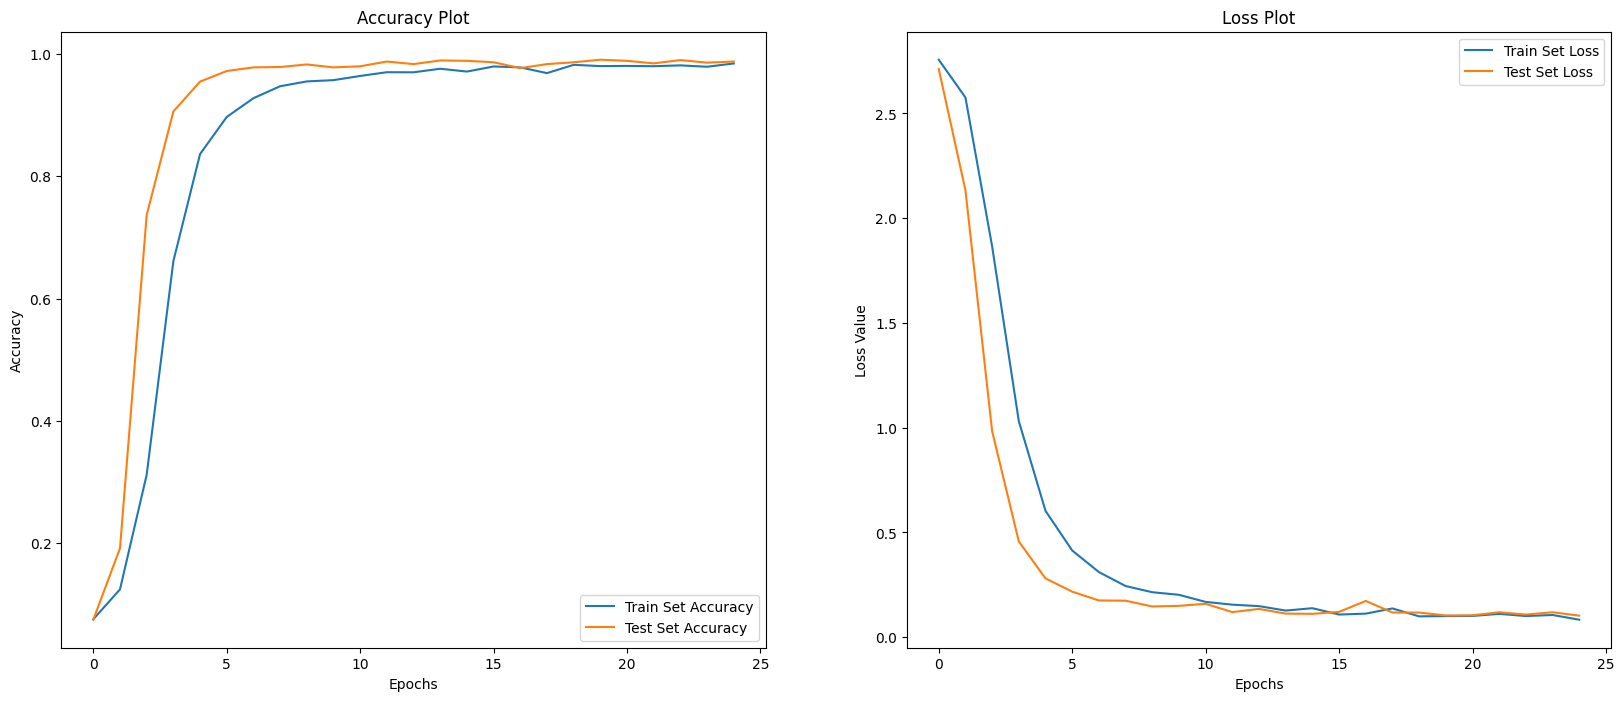

In [ ]:
figure = plt.figure(figsize=(20, 8))

figure.add_subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Set Accuracy')
plt.plot(history.history['val_accuracy'], label='Test Set Accuracy')
plt.title('Accuracy Plot')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')

figure.add_subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Set Loss')
plt.plot(history.history['val_loss'], label='Test Set Loss')
plt.title('Loss Plot')
plt.xlabel('Epochs')
plt.ylabel('Loss Value')
plt.legend(loc='upper right')

plt.show()

Now let's look at metrics

In [ ]:
# this line generates predicted
# values for the test input data
ypred = model.predict(X_test)

# this line finds the index of the highest predicted value
# for each predicted sample. This converts the predicted
# probabilities into the corresponding class labels.
# The updated values are stored back in `ypred`
ypred = np.argmax(ypred, axis=1)

# this line finds the index of the highest
# true value for each true sample in the test data
Y_test_hat = np.argmax(Y_test, axis=1)
print(classification_report(Y_test_hat, ypred))

53/53 [==============================] - 2s 27ms/step
              precision    recall  f1-score   support

           0       0.98      0.97      0.98       124
           1       0.99      1.00      1.00       113
           2       1.00      1.00      1.00        78
           3       0.98      1.00      0.99       107
           4       0.98      0.99      0.98        89
           5       0.99      1.00      0.99        99
           6       0.96      0.99      0.98       104
           7       1.00      0.98      0.99       133
           8       1.00      0.95      0.97       122
           9       0.99      0.99      0.99        88
          10       0.98      0.99      0.99       115
          11       1.00      0.99      1.00       116
          12       0.98      0.99      0.98       132
          13       1.00      0.99      1.00       118
          14       0.99      1.00      0.99       137

    accuracy                           0.99      1675
   macro avg       0.99   

As we can see, the metrics are ok. Every metric of every predicted class is higher than 98%, which is pretty good.

Saving model

In [ ]:
model.save('model.h5')

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In case we need it later

### Calculation function and tests

In [ ]:
# load model weights from file
model = keras.models.load_model('/content/drive/MyDrive/Notebooks/calculator of handwritten digits/model.h5')

In [ ]:
def test_pipeline(image_path):
    # a list for detected symbols
    chars = []
    img = cv2.imread(image_path)
    img = cv2.resize(img, (800, 800))
    # turn image to grayscale
    img_gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    # drawing edges of symbols on images
    edged = cv2.Canny(img_gray, 30, 150)
    # getting edges and sorting them left to right to read expression
    contours = cv2.findContours(edged.copy(), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    contours = imutils.grab_contours(contours)
    contours = sort_contours(contours, method="left-to-right")[0]
    labels = ['0', '1', '2', '3', '4', '5', '6', '7', '8', '9', 'add', 'div', 'dec', 'mul', 'sub']

    for c in contours:
        # here we're getting height and width of the box of a symbol
        (x, y, w, h) = cv2.boundingRect(c)
        # this is such a crutch but I couldn't come up with better solution
        if 20<=w:
            # getting a region of interest for a symbol
            roi = img_gray[y:y+h, x:x+w]
            # setting threshold to make an image b&w
            thresh = cv2.threshold(roi, 0, 255, cv2.THRESH_BINARY_INV | cv2.THRESH_OTSU)[1]
            # resizing the image so that both height and width were less than
            # 32 pixels so we could put an image to predictor
            (th, tw) = thresh.shape
            if tw > th:
                thresh = imutils.resize(thresh, width=32)
            if th > tw:
                thresh = imutils.resize(thresh, height=32)
            (th, tw) = thresh.shape
            dx = int(max(0, 32 - tw) / 2.0)
            dy = int(max(0, 32 - th) / 2.0)
            # adding padding to image to make it square-shaped (32x32)
            padded = cv2.copyMakeBorder(thresh,top=dy,bottom=dy,left=dx,right=dx,borderType=cv2.BORDER_CONSTANT,value=(0, 0, 0))
            padded = cv2.resize(padded, (32, 32))
            padded = np.array(padded)
            # binarize an image
            padded = padded/255.
            # reshaping image to (batch_size, height, width)
            padded = np.expand_dims(padded, axis=0)
            # reshaping image to (batch_size, height, width, num_channels)
            padded = np.expand_dims(padded, axis=-1)
            # so now our image is 32x32 and and it's binarized
            # and we can predict it's label
            pred = model.predict(padded)
            pred = np.argmax(pred, axis=1)
            label = labels[pred[0]]
            chars.append(label)
            # drawing bounding boxes and predicted label over image
            cv2.rectangle(img, (x, y), (x+w, y+h), (0, 0, 255), 2)
            cv2.putText(img, label, (x-5, y), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0, 0, 255))

    figure = plt.figure(figsize=(10, 10))
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    plt.imshow(img)
    plt.show()

    # changing labels to operators and calculating result
    expression = ''

    for char in chars:
      if char == 'add':
        char = '+'
      elif char == 'sub':
        char = '-'
      elif char == 'div':
        char = '/'
      elif char == 'mul':
        char = '*'

      expression += char

    print(f'Your solved expression: {expression} = {eval(expression)}')

1/1 [==============================] - 0s 24ms/step


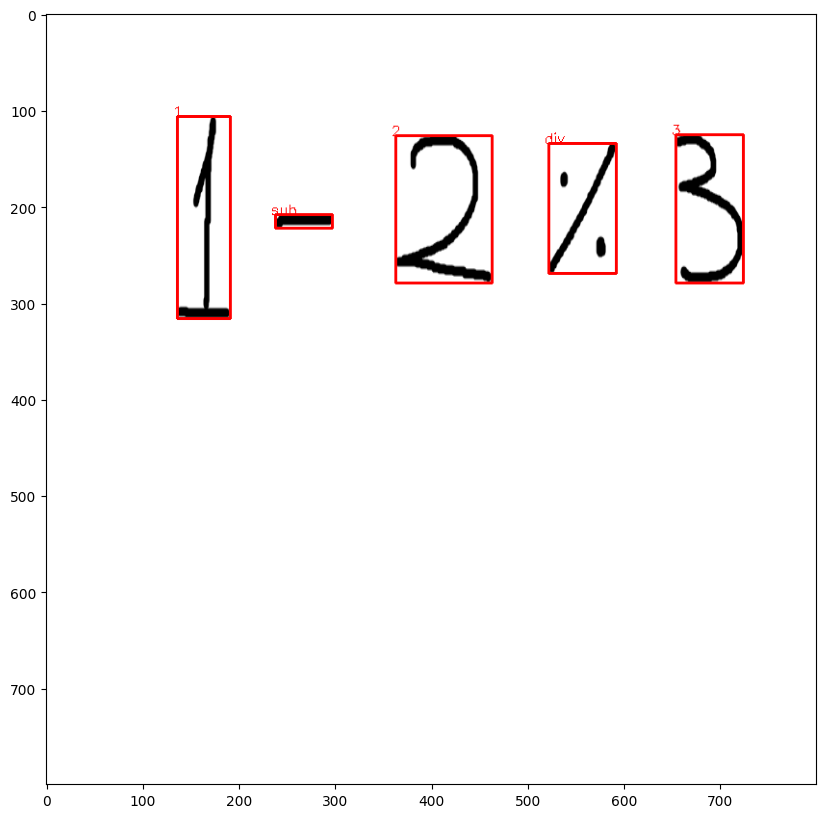

Your solved expression: 1-2/3 = 0.33333333333333337


In [ ]:
test_pipeline('/content/drive/MyDrive/Notebooks/calculator of handwritten digits/test.png')

1/1 [==============================] - 0s 21ms/step


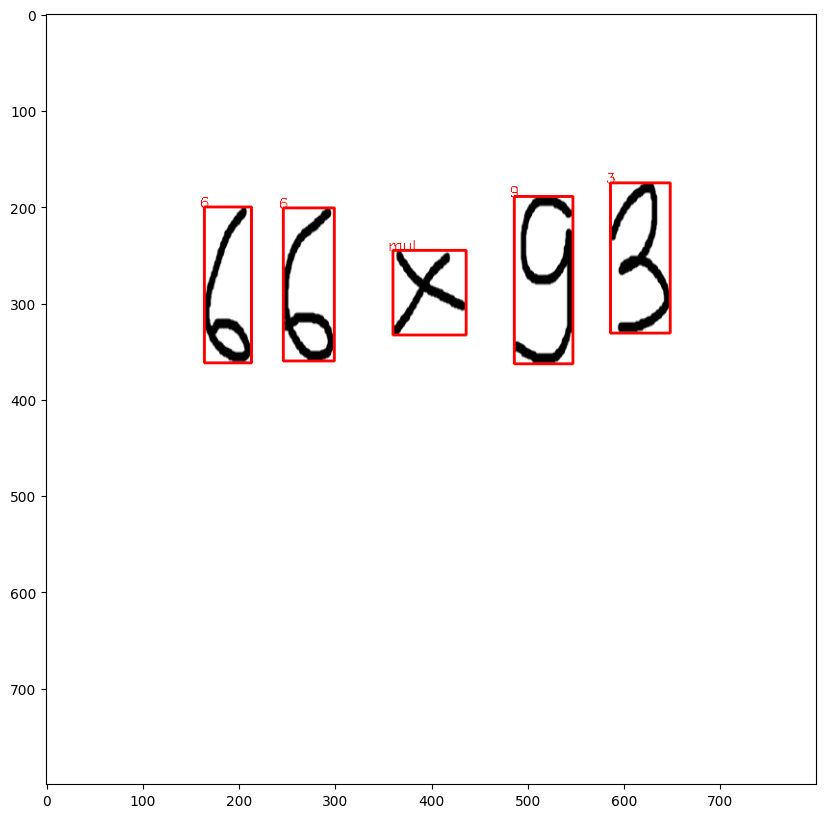

Your solved expression: 66*93 = 6138


In [ ]:
test_pipeline('/content/drive/MyDrive/Notebooks/calculator of handwritten digits/test1.png')

As we can see algorithm is working but is not good enough to detect objects that's have a big difference in size and it still makes mistakes (it detects decimal as 8).

### Thoughts on how to improve model

* To improve model performance I could use other, probably more
qualitative, dataset, for example (https://www.kaggle.com/datasets/xainano/handwrittenmathsymbols/data).
* Also it's nessesary to remake a detection algorithm so we could detect any objects we want including decimals, roots, integrals etc.